# Time Domain Processing

Here we will use standard **Librosa** library to apply discrete time mathematical operations directly on raw audio samples. We will consider a human speech wav file and look over an application of time domain processing. This includes
1. Voiced vs Unvoiced vs Silence Frames Detection
2. Speaker Pitch Estimation

Mounted at /content/drive


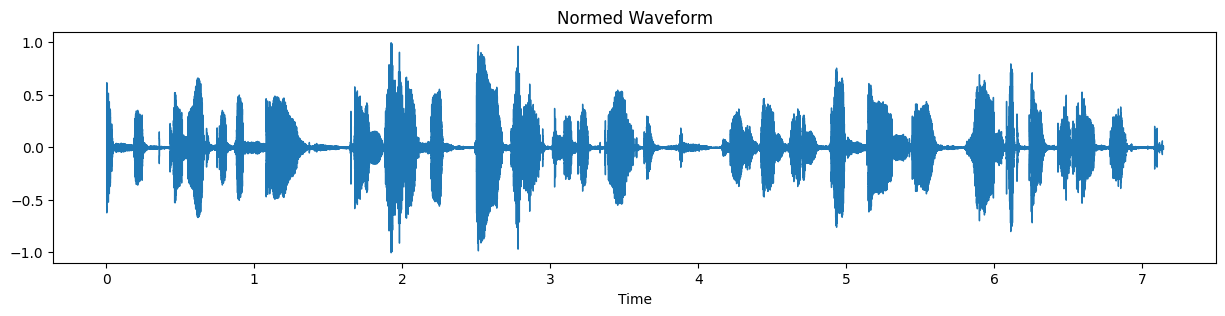

In [ ]:
# Load wav file, displaying and plotting waveform
from IPython.display import Audio, display
import librosa
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

ASSETS_DIR = "/content/drive/MyDrive/SIPLAB/AudioSpeechSamples/"
SPEECH_WAV = ASSETS_DIR + "humanSpeech/speech_sample.wav"
y, sr = librosa.load(SPEECH_WAV, sr=16000)
y_normed = librosa.util.normalize(y)

display(Audio(y_normed, rate=sr, normalize=False))

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,3))

librosa.display.waveshow(y_normed, sr=sr, ax=ax)
ax.set(title='Normed Waveform')
ax.label_outer()

In [ ]:
import numpy as np

# Creating overlapped frames of audio | Frame length : 25ms | Hop Length : 10ms
FRAME_SIZE = 0.032
HOP_SIZE = 0.016
FRAME_LENGTH = int(sr * FRAME_SIZE) #400 samples
HOP_LENGTH = int(sr * HOP_SIZE)

audio_frames = np.array([y_normed[i:i+FRAME_LENGTH] for i in range(0, len(y_normed)-FRAME_LENGTH, HOP_LENGTH)])
print("Generated Array of Frames of Audio : ", audio_frames.shape)

Generated Array of Frames of Audio :  (445, 512)


## Autocorrelation

We will apply below mathematical computation for each frame to get correlation among the samples. If a frame has samples periodical in nature, then we get peaks on autocorrelation curve (as in voiced samples where sounds are produced by periodically vibrating vocal folds).

Auto correlation sequence of a mean substracted frame x[n] :


 <center> $r_{xx}$[k] = $\frac{1}{r_{xx}[0]}\sum_{n=0}^{N}$ x[n]x[n+k]
$\;\;\;\;$ k = ...,-2,-1,0,1,2,... </center>

We do mean subtraction along the frames to adhere to the formula of covariance.

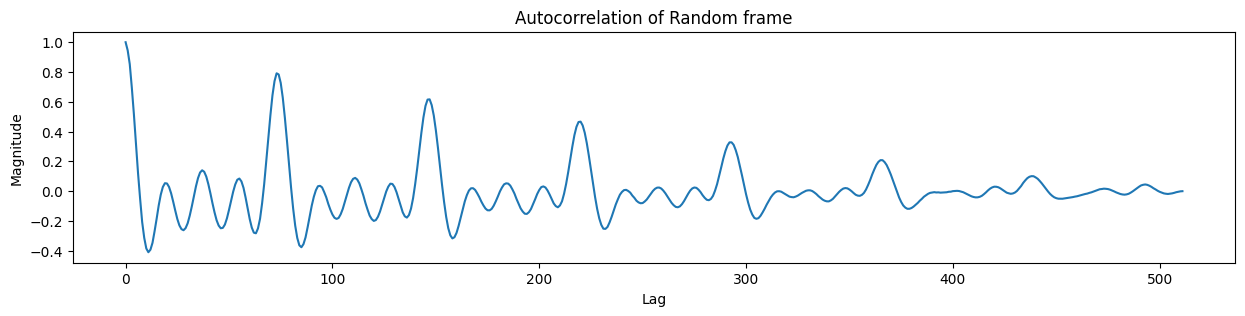

In [ ]:
# Picking up random frame, getting autocorrelation and plotting
import random

frame = random.choice(audio_frames)
frame_autoCorrelated = librosa.autocorrelate(frame)
autoCorrData = frame_autoCorrelated/frame_autoCorrelated[0]

plt.figure(figsize=(15,3))
plt.plot(autoCorrData)
plt.title("Autocorrelation of Random frame")
plt.ylabel("Magnitude")
plt.xlabel("Lag")
plt.show()

In [ ]:
# Extract number of zero crossings
z = librosa.zero_crossings(y_normed)
print("Number of zero crossings : ", np.sum(z == 1))
print("Indices at which zero crossings occur : ", np.nonzero(z)[0])

Number of zero crossings :  23122
Indices at which zero crossings occur :  [     0      1      2 ... 114231 114234 114235]


## Non uniform quantization | Companding

Till this point we were dealing with uniformly quantized audio samples. And with uniform quantization, SNR generally decreases due to quantization errors involved. Typically signal amplitudes range between very large and very small amplitudes. But most of the speech signal content have information in smaller amplitude samples. Hence we should give more resolution (smaller quantization step size) to smaller amplitudes compared to higher amplitudes than giving equal resolution to whole signal.

We are applying mu-Law Compression, notice how the smaller amplitudes are having scaled up resolution.

Uncompressed RAW audio : 


Compressed audio : 


Companded audio : 


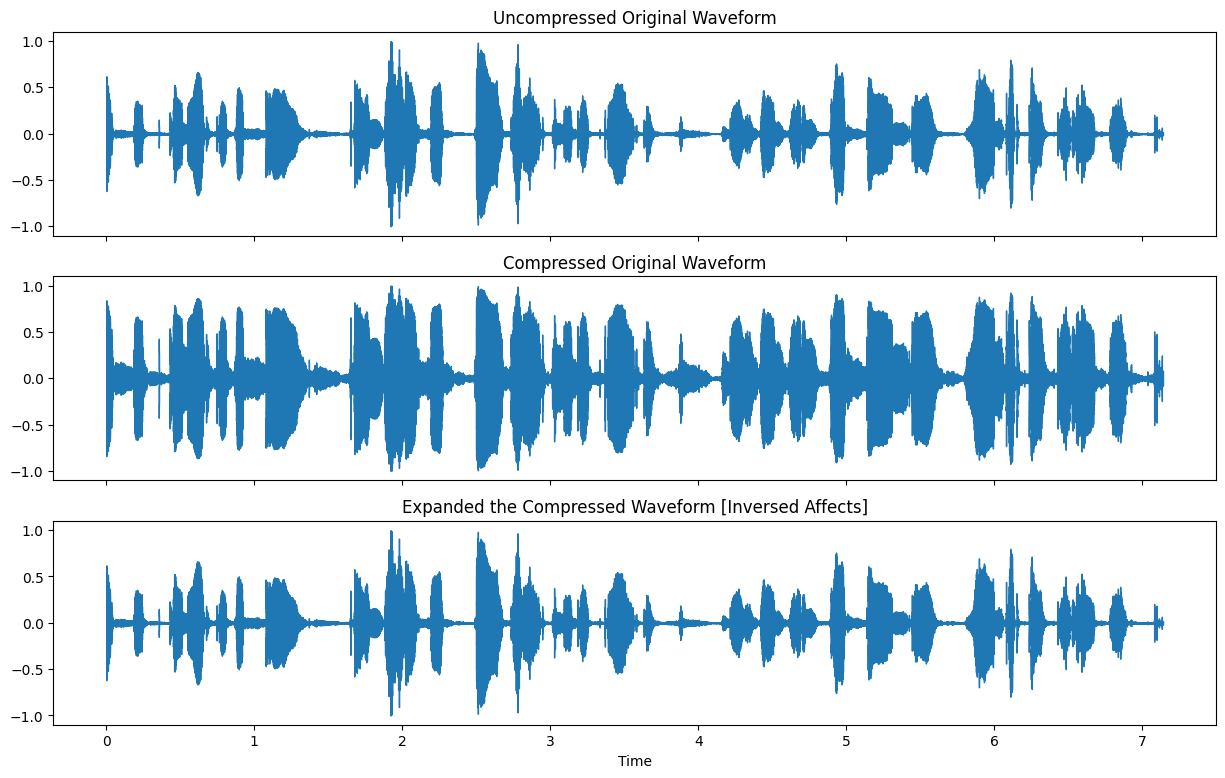

In [ ]:
y_compressed = librosa.mu_compress(y_normed, mu=15, quantize=False)
y_expanded = librosa.mu_expand(y_compressed, mu=15, quantize=False)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(15, 9))

librosa.display.waveshow(y_normed, sr=sr, ax=ax[0])
ax[0].set(title='Uncompressed Original Waveform')
ax[0].label_outer()

librosa.display.waveshow(y_compressed, sr=sr, ax=ax[1])
ax[1].set(title='Compressed Original Waveform')
ax[1].label_outer()

librosa.display.waveshow(y_expanded, sr=sr, ax=ax[2])
ax[2].set(title='Expanded the Compressed Waveform [Inversed Affects]')
ax[2].label_outer()

print("Uncompressed RAW audio : ")
display(Audio(y_normed, rate=sr, normalize=False))

print("Compressed audio : ")
display(Audio(y_compressed, rate=sr, normalize=False))

print("Companded audio : ")
display(Audio(y_expanded, rate=sr, normalize=False))

# Towards Applications

## Voiced vs Unvoiced vs Silence Frame Detection

We will process wavfile with both voiced and unvoiced sounds. Voiced sounds are produced by vibrating vocal folds, one can feel the vibrations by placing hand on throat while producing voiced sounds. On the other hand, unvoiced sounds are produced by gaussian noisy excitation through our vocal tract.

<img src ="https://raw.githubusercontent.com/Sreeakanth/SpeechSystems/master/VoicedUnvoiced.png" width = "800px" height = "400px" >

Above figure represents a frame of voiced and unvoiced speech portion. Also  these plots contain autocorrelation of frames. Clearly periodicity is captured for voiced frames autocorrelation.

## Pitch Estimation
While deciding between voiced vs unvoiced, we look for magnitude of first periodic peak and if magnitude is greater than threshold, we label it as **voiced**.
When a frame is detected as voiced, then we can look for first periodic peak. Lag corresponding to distance between n=0 and "n" where first peak occurs is nothing but the **pitch period**.

#### Plotting Energy and RMS using Librosa

<ul type="circle" >

<li> Let x[n] be the frame of the signal. The energy of the signal can be computed as </li>

<br>

$$ \sum_n \left| x(n) \right|^2 $$

<li>The root-mean-square energy (RMSE) in a signal is defined as</li>

$$ \sqrt{ \frac{1}{N} \sum_n \left| x(n) \right|^2 } $$

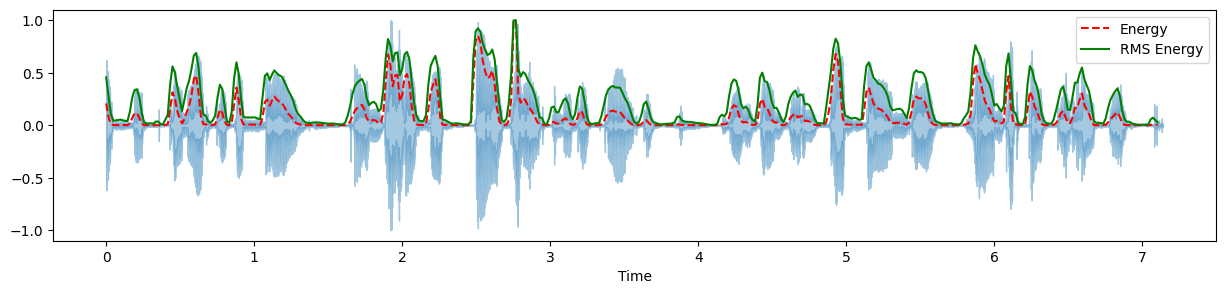

In [ ]:
ASSETS_DIR = "/content/drive/MyDrive/SIPLAB/AudioSpeechSamples/"
SPEECH_AMAZING_WAV = ASSETS_DIR + "humanSpeech/speech_sample.wav"
y, sr = librosa.load(SPEECH_AMAZING_WAV, sr=16000)
y_normed = librosa.util.normalize(y)

display(Audio(y_normed, rate=sr, normalize=False))

FRAME_SIZE = 0.032
HOP_SIZE = 0.016
FRAME_LENGTH = int(sr * FRAME_SIZE) #400 samples
HOP_LENGTH = int(sr * HOP_SIZE)

audio_frames = np.array([y_normed[i:i+FRAME_LENGTH] for i in range(0, len(y_normed)-FRAME_LENGTH, HOP_LENGTH)])

energies = np.array([sum(abs(frame)**2) for frame in audio_frames])
rms_energies = np.array([np.sqrt(sum(abs(frame)**2)/FRAME_LENGTH) for frame in audio_frames])
frames = range(len(energies))
t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

plt.figure(figsize=(15, 3))
librosa.display.waveshow(y_normed, sr=sr, alpha=0.4)
plt.plot(t, energies/energies.max(), 'r--', label="Energy")                 # normalized for visualization
plt.plot(t, rms_energies/rms_energies.max(), color='g', label="RMS Energy") # normalized for visualization
plt.legend()
plt.show()

#### Pitch Estimation and Voiced vs Unvoiced vs Silence Detection

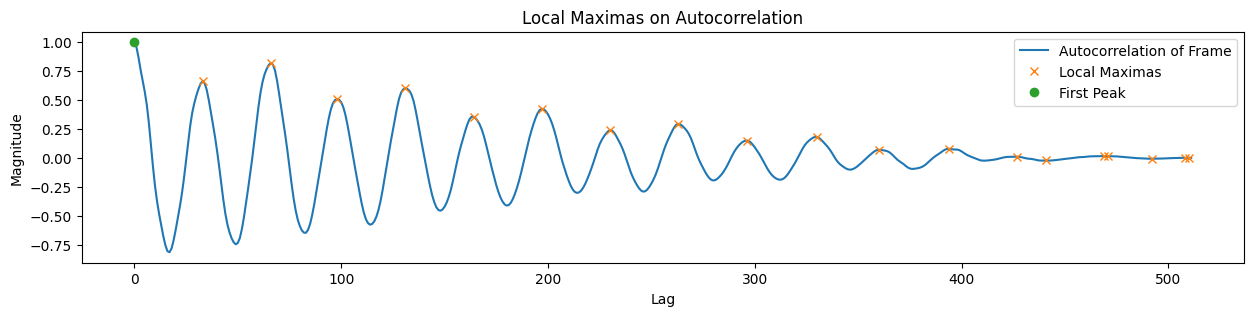

In [ ]:
from scipy.signal import find_peaks

# Helper functions

def AutoCorrelation(frame):
  output = librosa.autocorrelate(frame)
  return output/output[0]

def getLocalMaximas(autoCorr_array):
  first_peak = autoCorr_array[0]
  indices, _ = find_peaks(autoCorr_array)
  maximas = autoCorr_array[indices]
  return first_peak, maximas, indices

# Testing Functions

frame = random.choice(audio_frames)
autoCorrData = AutoCorrelation(frame)
first_peak, maximas, indices = getLocalMaximas(autoCorrData)

plt.figure(figsize=(15,3))
plt.plot(autoCorrData, label="Autocorrelation of Frame")
plt.plot(indices, maximas, "x", label="Local Maximas")
plt.plot(0, first_peak, "o", label="First Peak")
plt.title("Local Maximas on Autocorrelation")
plt.ylabel("Magnitude")
plt.xlabel("Lag")
plt.legend()
plt.show()

In [ ]:
# Voiced vs Unvoiced Estimation

def voiced_unvoiced(maximas, indices, peakThreshold = 0.5, f_min = 50,  f_max = 300):
  secondPeak = maximas[np.argmax(maximas)]
  secondPeakIndex = indices[np.argmax(maximas)]

  # fundamental frequency
  f_0 = 16000/secondPeakIndex

  if (f_0 > f_min) and (f_0 < f_max) and (secondPeak > peakThreshold):
    return ("voiced", f_0)
  else:
    return ("unvoiced", 0)

Estimated Pitch Frequency :  219.92612322084582 Hz


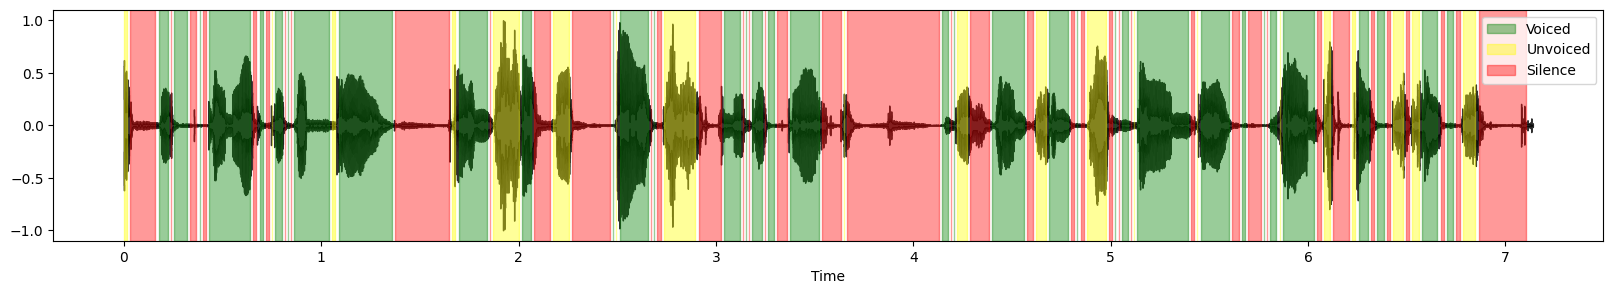

In [ ]:
energy_normed = energies/energies.max()
silence_energy_threshold = 0.05

f0_s = []
decisions = []

for i in range(len(audio_frames)):
  autoCorrData = AutoCorrelation(audio_frames[i])
  _, maximas, indices = getLocalMaximas(autoCorrData)
  decision, f_0 = voiced_unvoiced(maximas, indices)
  f0_s.append(f_0)

  if decision == "voiced":
    decisions.append(0)
  else:
    if energy_normed[i] > silence_energy_threshold:
      decisions.append(1)
    else:
      decisions.append(2)

decisions = np.array(decisions)
f0_s = np.array(f0_s)

# pitch frequency
valid_frames = f0_s[f0_s > 0]
f0 = sum(valid_frames)/len(valid_frames)
print("Estimated Pitch Frequency : ", f0, "Hz")

# Plotting decision regions
fig, ax = plt.subplots(figsize=(20, 3))
librosa.display.waveshow(y_normed, sr=sr, alpha=0.8, color="black")
ax.fill_between(t, 0, 1, where = decisions == 0, color='green', alpha=0.4, transform=ax.get_xaxis_transform(), label="Voiced")
ax.fill_between(t, 0, 1, where = decisions == 1, color='yellow', alpha=0.4, transform=ax.get_xaxis_transform(), label="Unvoiced")
ax.fill_between(t, 0, 1, where = decisions == 2, color='red', alpha=0.4, transform=ax.get_xaxis_transform(), label="Silence")
plt.legend()
plt.show()

#### Working with singer's recording | Since singers are known to change their pitch while singing, we will also tracking pitch frequencies

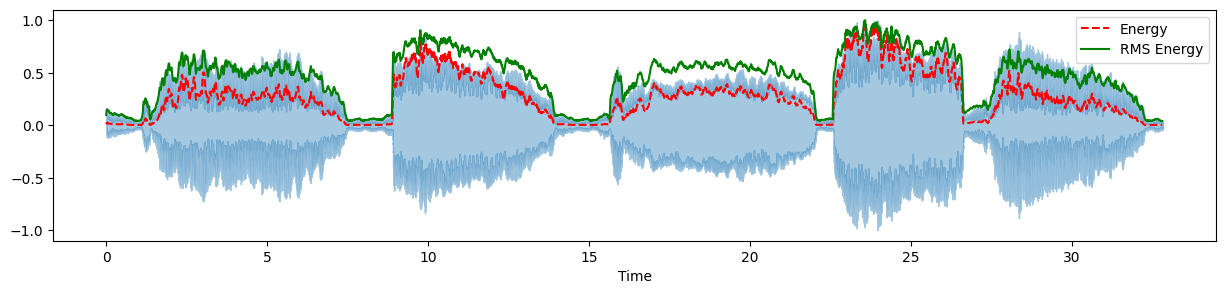

In [ ]:
ASSETS_DIR = "/content/drive/MyDrive/SIPLAB/AudioSpeechSamples/"
SPEECH_AMAZING_WAV = ASSETS_DIR + "humanSpeech/sa-pa-sa.wav"
y, sr = librosa.load(SPEECH_AMAZING_WAV, sr=16000)
y_normed = librosa.util.normalize(y)

display(Audio(y_normed, rate=sr, normalize=False))

FRAME_SIZE = 0.025
HOP_SIZE = 0.010
FRAME_LENGTH = int(sr * FRAME_SIZE) #400 samples
HOP_LENGTH = int(sr * HOP_SIZE)

audio_frames = np.array([y_normed[i:i+FRAME_LENGTH] for i in range(0, len(y_normed)-FRAME_LENGTH, HOP_LENGTH)])

energies = np.array([sum(abs(frame)**2) for frame in audio_frames])
rms_energies = np.array([np.sqrt(sum(abs(frame)**2)/FRAME_LENGTH) for frame in audio_frames])
frames = range(len(energies))
t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

plt.figure(figsize=(15, 3))
librosa.display.waveshow(y_normed, sr=sr, alpha=0.4)
plt.plot(t, energies/energies.max(), 'r--', label="Energy")                 # normalized for visualization
plt.plot(t, rms_energies/rms_energies.max(), color='g', label="RMS Energy") # normalized for visualization
plt.legend()
plt.show()

## Pending Works (To be Continued)

1. Plot voiced vs unvoiced decisions for singer's speech file
2. Plot pitch frequency tracking of singer
3. Estimate fundamental frequency using another algorithm called **pYAAPT**
4. Estimate voice activity detection using **webrtc-vad** package (widely used in real time deployments)